In [1]:
import zipfile
import os
import time
#
from google.colab import drive
from PIL import Image

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_file = '/content/drive/MyDrive/archive.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

['.config', 'cats', 'drive', 'sample_data']


In [4]:
#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [5]:
#Importing data
data_path = './cats/cats'#/content/drive/MyDrive/cats/cats/'
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 15747 files belonging to 1 classes.


# Новый раздел

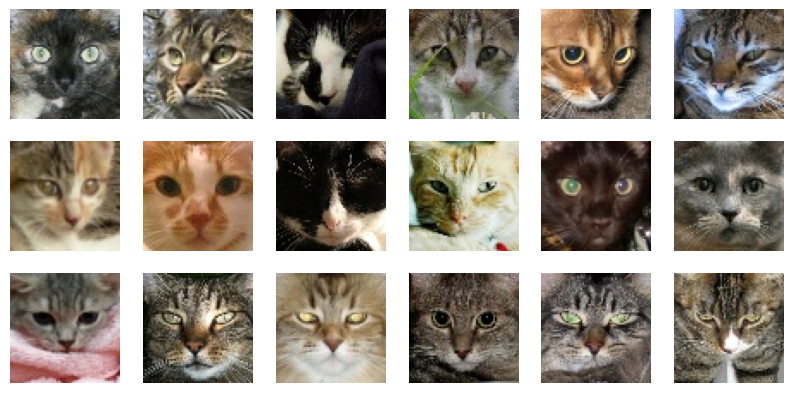

In [6]:
plt.figure(figsize=(10, 10))
for images in data.take(1):
    for i in range(18):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
def normalize(image):
    image = tf.cast(image/255. ,tf.float32)
    return image

data = data.map(normalize)

In [8]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

# Новый раздел

(-0.5, 63.5, 63.5, -0.5)

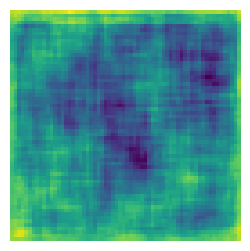

In [9]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Cat = generator(seed, training=False)
#Plotting the image output of generator without training
plt.figure(figsize=(3, 3))
plt.imshow(Generated_Cat[0, :, :, 0])
plt.axis("off")

In [10]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [11]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Cat)
print (Discriminator_Verdict)

tf.Tensor([[0.4995267]], shape=(1, 1), dtype=float32)


In [12]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [13]:
# #Defining the number of epochs
# epochs = 3
# for i in [0.00005, 0.0001, 0.00015, 0.0002]:
#   #The optimizers for Generator and Discriminator
#   discriminator_opt = tf.keras.optimizers.Adam(i,0.5)
#   generator_opt = tf.keras.optimizers.Adam(i,0.5)
#   #To compute cross entropy loss
#   loss_fn = tf.keras.losses.BinaryCrossentropy()

#   #Defining GAN Model
#   model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#   #Compiling GAN Model
#   model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#   #Fitting the GAN
#   history = model.fit(data, epochs=epochs,verbose=0)
#   print(f"rate {i} - dloss {history.history['d_loss'][-1]}, gloss {history.history['g_loss'][-1]}")

In [14]:
# epochs = 3
# for i in [0.0002, 0.0003, 0.0005, 0.001]:
#   #The optimizers for Generator and Discriminator
#   discriminator_opt = tf.keras.optimizers.Adam(i,0.5)
#   generator_opt = tf.keras.optimizers.Adam(i,0.5)
#   #To compute cross entropy loss
#   loss_fn = tf.keras.losses.BinaryCrossentropy()

#   #Defining GAN Model
#   model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#   #Compiling GAN Model
#   model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#   #Fitting the GAN
#   history = model.fit(data, epochs=epochs,verbose=0)
#   print(f"rate {i} - dloss {history.history['d_loss'][-1]}, gloss {history.history['g_loss'][-1]}")

In [15]:
# epochs = 3
# for i in [Adam, Adamax, RMSprop, SGD]:
#   #The optimizers for Generator and Discriminator
#   discriminator_opt = i(0.0005,0.5)
#   generator_opt = i(0.0005,0.5)
#   #To compute cross entropy loss
#   loss_fn = tf.keras.losses.BinaryCrossentropy()

#   #Defining GAN Model
#   model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#   #Compiling GAN Model
#   model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#   #Fitting the GAN
#   history = model.fit(data, epochs=epochs,verbose=0)
#   print(f"rate {i} - dloss {history.history['d_loss'][-1]}, gloss {history.history['g_loss'][-1]}")

In [16]:
# epochs = 3
# for i in [0.2, 0.5, 0.7, 0.9]:
#   #The optimizers for Generator and Discriminator
#   discriminator_opt = Adam(0.0005,i)
#   generator_opt = Adam(0.0005,i)
#   #To compute cross entropy loss
#   loss_fn = tf.keras.losses.BinaryCrossentropy()

#   #Defining GAN Model
#   model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#   #Compiling GAN Model
#   model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#   #Fitting the GAN
#   history = model.fit(data, epochs=epochs,verbose=0)
#   print(f"rate {i} - dloss {history.history['d_loss'][-1]}, gloss {history.history['g_loss'][-1]}")

In [17]:
epochs = 50

#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adam(0.00015,0.5)
generator_opt = tf.keras.optimizers.Adam(0.00015,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/50
247/247 [==============================] - 67s 196ms/step - d_loss: 0.6543 - g_loss: 0.9697
Epoch 2/50
247/247 [==============================] - 48s 193ms/step - d_loss: 0.6733 - g_loss: 0.8757
Epoch 3/50
247/247 [==============================] - 48s 195ms/step - d_loss: 0.6718 - g_loss: 0.8926
Epoch 4/50
247/247 [==============================] - 49s 200ms/step - d_loss: 0.6888 - g_loss: 0.8114
Epoch 5/50
247/247 [==============================] - 48s 196ms/step - d_loss: 0.6812 - g_loss: 0.8486
Epoch 6/50
247/247 [==============================] - 49s 197ms/step - d_loss: 0.6765 - g_loss: 0.9018
Epoch 7/50
247/247 [==============================] - 49s 198ms/step - d_loss: 0.6725 - g_loss: 0.8913
Epoch 8/50
247/247 [==============================] - 48s 195ms/step - d_loss: 0.6763 - g_loss: 0.8722
Epoch 9/50
247/247 [==============================] - 49s 197ms/step - d_loss: 0.6809 - g_loss: 0.8289
Epoch 10/50
247/247 [==============================] - 49s 198ms/step - d

In [18]:
d_loss = history.history['d_loss']
g_loss = history.history['g_loss']

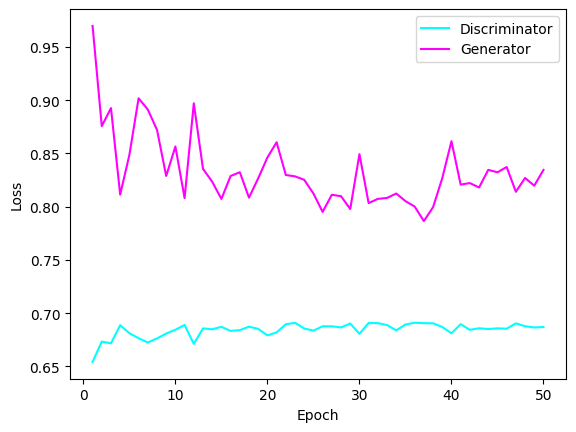

In [20]:
X = range(1,51)
plt.plot(X, d_loss, color='cyan', label='Discriminator')
plt.plot(X, g_loss, color='magenta', label='Generator')
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [21]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Cat_Generator():
    Generated_Cats = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Cats.append(img)
            img.save("Cats{:02d}.png".format(i))
    return Generated_Cats

#Generating images
Images = Cat_Generator()

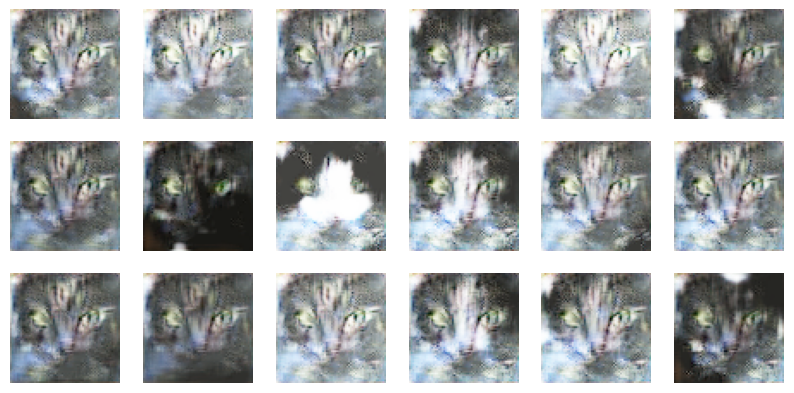

In [22]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(6, 6, 18)
i=1
for images in Images:
  ax = plt.subplot(6, 6, i)
  plt.imshow(images)
  plt.axis("off")
  i+=1